# Distribution models
A notebook to test the implementation of fitting different distributions to the data.

## Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../python/')
import ephys

mountainlab_pytools module not installed. Some functions from the ephys package may not be available.


In [3]:
cmap = plt.get_cmap('bone')

In [9]:
import importlib
importlib.reload(ephys)

mountainlab_pytools module not installed. Some functions from the ephys package may not be available.


<module 'ephys' from '../python/ephys.py'>

## Gaussian-mixture model

### Multivariate Gaussian CDF
https://upload.wikimedia.org/wikipedia/commons/a/a2/Cumulative_function_n_dimensional_Gaussians_12.2013.pdf

The above proof gives an idea of how to compute the cumulative distribution function for a multivariate Gaussian distribution. However, it has an algebraic error near the end that incorrectly computes the cdf for odd values of dimensionality. TODO: give corrected proof

### Test with synthetic data

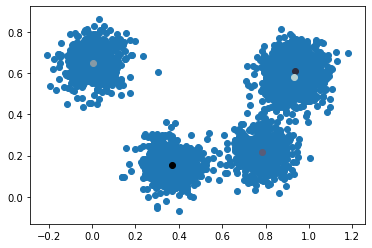

In [13]:
k = 5 # number of clusters
X, mu, Sigma = [], [], []
for k_ in range(k):
    mu.append(np.random.rand(2))
    #Sigma_ = np.random.rand(2, 2)
    #Sigma.append((Sigma_.dot(Sigma_.T))**0.5) # random positive semi-definite matrix
    Sigma.append(0.005*np.eye(2))
    X.append(np.random.multivariate_normal(mean=mu[-1], cov=Sigma[-1], size=500))

# Shuffle data from all distributions
X_all = np.vstack(X)
np.random.shuffle(X_all) # modifies in place

# Plot data
plt.scatter(X_all[:, 0], X_all[:, 1])
for k_ in range(k):
    plt.scatter(mu[k_][0], mu[k_][1], color=cmap(k_/k))

Fitting k-means model...
Converged after 19 iterations.
Fitting GM model...
Converged after 56 iterations.


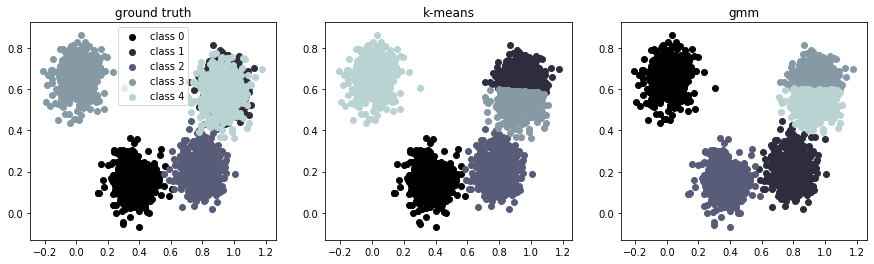

In [15]:
# Fit k-means model
print('Fitting k-means model...')
kmeans = ephys.KMeans(k)
kmeans.fit(X_all, init_method='random')
km_labels = kmeans.predict(X_all) # initial cluster labels

# Fit Gaussian-mixture model
print('Fitting GM model...')
gmm = ephys.GaussianMixture(k)
gmm.fit(X_all)
gmm_labels = gmm.predict(X_all)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for k_ in range(k):
    ax[0].scatter(X[k_][:, 0], X[k_][:, 1],
                  color=cmap(k_/k), label='class {}'.format(k_))
    ax[1].scatter(X_all[km_labels == k_, 0], X_all[km_labels == k_, 1], 
                  color=cmap(k_/k), label='class {}'.format(k_))
    ax[2].scatter(X_all[gmm_labels == k_, 0], X_all[gmm_labels == k_, 1], 
                  color=cmap(k_/k), label='class {}'.format(k_))

ax[0].legend()
ax[0].set_title('ground truth')
ax[1].set_title('k-means')
ax[2].set_title('gmm');

## Archive

In [ ]:
import operator

class Distribution:
    
    def __init__(self):
        self._TestResult = namedtuple('TestResult', ['statistic', 'pvalue'])
        self._name = 'distribution'
        
    @property
    def params(self):
        return self._params()
        
    def _params(self):
        raise NotImplementedError
        
    @property
    def name(self):
        return self._name
        
    def fit(self, X, **kwargs):
        return self._fit(X, **kwargs)
    
    def _fit(self, X, **kwargs):
        raise NotImplementedError
        
    def pdf(self, X, **kwargs):
        return self._pdf(X, **kwargs)
        
    def _pdf(self, X, **kwargs):
        raise NotImplementedError
        
    def cdf(self, X, **kwargs):
        return self._cdf(X, **kwargs)
    
    def _cdf(self, X, **kwargs):
        raise NotImplementedError
    
class Exponential(Distribution):
    
    def __init__(self):
        super().__init__()
        self._name = 'exponential'
        
        # Set parameters
        self._lam = None
        
    def _params(self):
        return {'lam': self._lam}
    
    def _fit(self, x):
        self._lam = 1.0/np.mean(x)
        
    def _pdf(self, x):
        return self._lam*np.exp(-self._lam*x)
    
    def _cdf(self, x):
        return 1.0 - np.exp(-self._lam*x)
    
    def _inv_cdf(self, F):
        return -(1.0/self._lam)*np.log(1.0 - F)
    
    def goodness_of_fit(self, x):
        # Sort random values
        x = np.sort(x)
        
        # Calculate ecdf
        ecdf = np.arange(len(x))/float(len(x))

        # Get KS statistic
        #return np.max(np.abs(self.cdf(x) - ecdf))
        result = stats.kstest(rvs=x, cdf=self.cdf)
        
        return self._TestResult(result[0], result[1])
        

class Gaussian(Distribution):
    
    def __init__(self):
        super().__init__()
        self._name = 'gaussian'
        
        # Set parameters
        self._mu = None
        self._Sigma = None
        
        # Feature placeholders
        self._m = None # number of dimensions
        
        # Cache costly calculations
        self._den = None # denominator of Gaussian (includes determinant)
        self._Sigma_inv = None # inverse of covariance
        
    def _params(self):
        if self._m == 1:
            return {'mu': self._mu.squeeze()[()],
                    'sigma': self._Sigma.squeeze()[()]**0.5}
        else:
            return {'mu': self._mu,
                    'Sigma': self._Sigma}
    
    def _format_data(self, X):
        if X.ndim == 1 and self._m is None:
            return X[:, np.newaxis]
        elif X.ndim == 2 and self._m is None:
            return X
        elif X.ndim == 1 and X.shape[0] == self._m:
            return X[np.newaxis, :]
        elif X.ndim == 1 and self._m == 1:
            return X[:, np.newaxis]
        elif X.ndim == 2 and X.shape[0] == self._m:
            return X.T
        elif X.ndim == 2 and X.shape[1] == self._m:
            return X
        else:
            raise SyntaxError('Data shape of [' + ','.join([str(n) for n in X.shape]) + '] not understood.')
    
    def _fit(self, X):
        
        X = self._format_data(X)
        
        N = X.shape[0] # number of samples
        m = X.shape[1] # number of dimensions
        
        # Maximum-likelihood estimation
        self._mu = np.mean(X, axis=0)
        self._Sigma = (1.0/N) * (X - self._mu).T.dot(X - self._mu)
        
        # Remember features
        self._m = m
        self._N = N
        
        # Reset cache
        self._den = None
        
    def _pdf(self, X):
        
        X = self._format_data(X)
        
        N = X.shape[0] # number of samples
        m = X.shape[1] # number of dimensions
        
        if self._den == None:
            self._den = np.sqrt(np.pi**m * np.linalg.det(self._Sigma))
        if self._Sigma_inv is None:
            self._Sigma_inv = np.linalg.inv(self._Sigma)
        num = np.exp(-0.5*np.diag((X - self._mu).dot(self._Sigma_inv.dot((X - self._mu).T))))
        
        return num / self._den
    
    def _cdf(self, X):
        if self._m == 1:
            # Assume X represents points in 1D space
            X = self._format_data(X)
            return stats.norm.cdf(X, loc=self._mu, scale=np.sqrt(self._Sigma))
        else:
            # Assume X represents Mahalanobis distances from the mean
            assert X.ndim == 1
            return self._multivariate_cdf(self._m, X)
        
    def _multivariate_cdf(self, m, r):
        if m == 1:
            return 2*(stats.norm.cdf(r, loc=0, scale=1) - 0.5)
        elif m == 2:
            return 1.0 - np.exp(-0.5*r**2)
        else:
            return self._multivariate_cdf(m-2, r) - r**(m-2)*np.exp(-0.5*r**2)/(m-2)
    
    def distance(self, X):
        """
        Returns the Mahalanobis distance between sample x and model mean mu:
        
        d^2(x, Sigma) = (x - mu)^T Sigma^-1 (x - mu)
        
        where Sigma and mu are the mean and covariance matrix of the sample set
        used to fit the model.
        
        Args:
        - X: Samples to query distance. Expected format is [N, m], where N is the
            number of samples, and m is the dimensionality.
        """
        # Format data
        X = self._format_data(X)
        
        return self._distance(X)
    
    def _distance(self, X):
        # Compute inverse covariance matrix if not already cached
        if self._Sigma_inv is None:
            self._Sigma_inv = np.linalg.inv(self._Sigma)
        
        # Calculate Mahalanobis distance
        return np.sqrt(np.diag((X - self._mu).dot(self._Sigma_inv.dot((X - self._mu).T))))
    
    def get_statistic(self, X, distribution='beta'):
        """
        Get the statistic of a set of observations X relative to the fit distribution.
        
        If X is part of the sample set used to fit the distribution, then:
        
        (N d^2)/(N-1)^2 ~ B(m/2, (N-m-1)/2)
        
        where N is the number of samples used to fit the distribution, m is the 
        dimensionality of each sample, and d^2 is the Mahalanobis distance between 
        the observation X and model mean mu.
        
        If X is a new observation independent of the original sample set, then:
        
        (N(N-m)d^2)/(m(N-1)^2) ~ F(m, N-m)
        
        where F is the F-distribution.
        
        (If the distribution was fit to the true population parameters, then chi-squared
        should be used.)
        
        Args:
        - X: Observation set to query. Shape [N' x m].
        - distribution: Type of distribution to test against. Options are beta or f.
        
        Returns:
        - stat: 1D array of length N' containing statistic of each observation in X.
        """
        # Format data
        X = self._format_data(X)
        
        # Use sample set dimensions
        N = self._N
        m = self._m
        
        # Calculate statistic for specified distribution
        if distribution.lower() == 'beta':
            return (N/(N-1)**2) * self._distance(X)**2
        elif distribution.lower() == 'f':
            return (N*(N-m))/(m*(N-1)**2) * self._distance(X)**2
        else:
            raise ValueError('Unknown distribution \'{}\''.format(distribution))
        
    def test_statistic(self, X, distribution='beta', q=0.95, test='>'):
        """
        Test the probability of observation X being a part of the fit distribution.
        See the get_statistic method for an explanation of the different 
        distributions.
        
        Args:
        - X: Observation set to query. Shape [N' x m].
        - distribution: Type of distribution to test against. Options are beta or f.
        - q: Percentile within distribution to test against. In other words, if q = 0.95,
            then the function tests the relationship of observation X to the 95th 
            percentile of the fit distribution.
        - test: Relationship to q to test. Options are >, >=, <, <=.
        
        Returns:
        - result: 1D boolean array of length N' containing results of relationship of 
            each observation to percentile q of distribution.
        """
        # Get statistic
        stat = self.get_statistic(X, distribution=distribution)
        
        # Use sample set dimensions
        N = self._N
        m = self._m
        
        # Calculate statistic at query percentile q
        if distribution.lower() == 'beta':
            stat_q = stats.beta.ppf(q, m/2, (N - m - 1)/2)
        elif distribution.lower() == 'f':
            stat_q = stats.f.ppf(q, m, N - m)
        else:
            raise ValueError('Unknown distribution \'{}\''.format(distribution))    
        
        # Get test operator
        ops = {'<':  operator.lt,
               '<=': operator.le,
               '>':  operator.gt,
               '>=': operator.ge}
        
        return ops[test](stat, stat_q)
    
    def goodness_of_fit(self, X, method='SW'):
        # No multivariate test implemented yet
        if self._m > 1:
            raise SyntaxError('Multivariate test not implemented.')
            
        # Format data
        X = self._format_data(X)
        
        # Kolmogorov-Smirnov test
        if method.lower() == 'ks':
            cdf = lambda x: stats.norm.cdf(x, loc=self._mu, scale=np.sqrt(self._Sigma))
            result = stats.kstest(rvs=X, cdf=cdf)
        # Shaprio-Wilk test
        elif method.lower() == 'sw':
            result = stats.shapiro(X)
        else:
            raise ValueError('Unknown method \'{}\''.format(method))
            
        return self._TestResult(result[0], result[1])
        
    
class LogGaussian(Gaussian):
    
    def __init__(self, **kwargs):
        
        super().__init__(**kwargs)
        self._name = 'log-gaussian'
        
    def _format_data(self, X):
        # Apply logarithmic transformation first
        X = np.log(X)
        
        if X.ndim == 1 and self._m is None:
            return X[:, np.newaxis]
        elif X.ndim == 2 and self._m is None:
            return X
        elif X.ndim == 1 and X.shape[0] == self._m:
            return X[np.newaxis, :]
        elif X.ndim == 1 and self._m == 1:
            return X[:, np.newaxis]
        elif X.ndim == 2 and X.shape[0] == self._m:
            return X.T
        elif X.ndim == 2 and X.shape[1] == self._m:
            return X
        else:
            raise SyntaxError('Data shape of [' + ','.join([str(n) for n in X.shape]) + '] not understood.')
            

class Poisson(Distribution):
    
    def __init__(self, lam, Lam=None, homogeneous=True):
        """
        Creates Poisson distribution model.

        Args:
        - lam: The rate parameter that characterizes a Poisson distribution.
            If creating a homogeneous model, lam is a constant. Otherwise,
            lam is a function that takes time as input and returns lambda.
        - Lam: The integral of the rate parameter function for a nonhomogeneous
            Poisson process. Lam should be a function that takes two inputs
            (time t and duration s) and returns the integral of the lambda 
            function from t to t+s.
        - homogeneous: If true, then lam is constant, and Lam is ignored. If
            False, then lam and Lam are expected to be functions as described.
        """
        super().__init__()
        self._name = 'poisson'
        
        self.homogeneous = homogeneous
        self._set_params(lam, Lam)
        
    def _set_params(self, lam, Lam):
        if self.homogeneous:
            self.lam = lambda t: lam
            self.Lam = lambda t, s: lam*s
        elif Lam is not None:
            self.lam = lam # function of (t)
            self.Lam = Lam # function of (t, s)
        else:
            raise ValueError('Lambda(t,s) must be provided for non-homogeneous processes.')
        
    def _params(self):
        if self.homogeneous:
            lam = self.lam(0)
        else:
            lam = self.lam
        return {'lam': lam,
                'Lam': self.Lam}
        
    def _array(self, a):
        """Ensures object is a numpy array"""
        if not isinstance(a, np.ndarray):
            return np.array([a])
        else:
            return a
       
    def _pdf(self, t, t_0=None):
        """
        Returns probability density of next inter-event interval
        at time t_0: f(t) = lam(t_0) e^(-lam(t_0)*t). Note that this function will be
        the same for all t for a homogeneous process, but will vary with t_0 for a 
        non-homogeneous process.

        Args:
        - t: Duration of the inter-event interval
        - t_0: Current time in process.
        """
        return self.lam(t_0)*np.exp(-self.lam(t_0)*t)
    
    def _cdf(self, t, t_0=None):
        """
        Returns cumulative probability distribution of next inter-event interval
        at time t_0: F(t) = 1 - e^(-lam(t_0)*t). Note that this function will be
        the same for all t for a homogeneous process, but will vary with t_0 for a 
        non-homogeneous process.

        Args:
        - t: Duration of the inter-event interval
        - t_0: Current time in process.
        """
        return 1.0 - np.exp(-self.lam(t_0)*t)
    
    def _inv_cdf(self, F, t_0=None):
        """
        Returns inverse cumulative probability distribution of next inter-event interval
        at time t_0: t(F) = -(1/lam(t_0)) log (1 - F). Note that this function will be
        the same for all F for a homogeneous process, but will vary with t_0 for a 
        non-homogeneous process.
        """
        return -(1.0/self.lam(t_0))*np.log(1.0 - F)
    
    def _factorial(self, n):
        """Returns n!"""
        if isinstance(n, np.ndarray):
            fact = np.zeros(n.size)
            for i, n_i in enumerate(n):
                fact[i] = np.prod(np.arange(max(n_i, 1))+1)
        else:
            fact = np.prod(np.arange(max(n_i, 1))+1)
    
        return fact
    
    def P(self, n, s, t=0):
        """Returns probability that N(s) = n""" 
        Lam = self.Lam(t, s)
        return np.exp(-Lam)*(np.power(Lam, n))/self._factorial(n)
    
    def times(self, interevent=True, **kwargs):
        """Returns event times sampled from Poisson distribution.
        
        Args:
        - interevent: If True, return times between events. 
            If False, return event times.
        - **kwargs: See _interevent_times() and _event_times()
        """
        if interevent:
            return self._interevent_times(**kwargs)
        else:
            return self._event_times(**kwargs)
        
    def _interevent_times(self, n=1, t_0=None, t_max=np.inf, **kwargs):
        """
        Returns interevent times.

        Args:
        - n: Number of interevent times to generate.
        - t_0: Current time in process.
        - t_max: Maximum interval between events to allow.

        Returns:
        - t: Interevent times of size n.
        """
        if (self.homogeneous) or (t_0 is not None):
            F = np.random.uniform(size=n)
            t = self._inv_cdf(F, t_0)
            t[t > t_max] = t_max
            return t
        else:
            t = self._event_times(**kwargs)
            return np.diff(t)
            
    def _event_times(self, s, t=0, t_max=np.inf):
        """
        Returns event times in interval [t, s)

        Args:
        - s: Duration of current process to sample events.
        - t: Start time in current process to sample events.
        - t_max: Maximum interval between events to allow.
        
        Returns:
        - t_event: Time of events in interval [t, s).
        """
        # Convert to arrays
        t = self._array(t)
        s = self._array(s)
        
        if self.homogeneous:
            # No pruning if homogeneous process
            N_s = self._events(s)
            t_event = np.sort(np.random.uniform(low=t, high=t+s, size=N_s))
            return t_event
        else:
            # Get event times with rate lambda_max
            t_0, lam_max = self._lam_max(t=t, s=s, return_argmax=True)
            N_s = self._events(t=t, s=s, t_0=t_0, t_max=t_max)
            t_event = np.sort(np.random.uniform(low=t, high=t+s, size=N_s))
            
            # Prune drip times to generate inhomogeneous process
            lam_t = self.lam(t_event)
            U = np.random.uniform(size=N_s)
            return t_event[U <= (lam_t / lam_max)]
           
    def _lam_max(self, s, t=0, return_argmax=False):
        """
        Returns the maximum rate parameter in interval [t, s).
        """
        neg_lam = lambda t: -self.lam(t)
        bounds = Bounds(t, t+s)
        soln = minimize(neg_lam, np.ones(t.shape), bounds=bounds)
        if return_argmax:
            return soln.x, -soln.fun
        else:
            return -soln.fun
          
    def _events(self, s, t=0, t_0=None, t_max=np.inf):
        """
        Returns number of events N(s) in interval [t, s) sampled from a
        Poisson distribution by generating inter-event intervals.

        Args:
        - s: Duration of current process to sample events.
        - t: Start time in current process to sample events.
        - t_0: Time in current process to calculate lambda
        - t_max: Maximum interval between events to allow. 

        Returns: 
        - n: Number of events in interval [t, s).
        """
        if (not self.homogeneous) and (t_0 is None):
            raise ValueError('t_0 must be specified by non-homogeneous process.')

        # Guess number of events as Poisson mean
        mean = self.Lam(t, s)
        chunk = max(int(mean), 1)
        T = np.cumsum(self.times(interevent=True, n=chunk, t_0=t_0, t_max=t_max))
        idx = np.searchsorted(T, s, side='left')
        n = idx

        # Continue sampling time until time s reached
        while (idx == T.size):
            T = np.cumsum(self.times(interevent=True, n=chunk, t_0=t_0, t_max=t_max)) + T[-1]
            idx = np.searchsorted(T, s, side='left')
            n += idx
            
        return n
    
    def events(self, s, t=0, t_max=np.inf):
        """
        Returns number of events N(s) in interval [t, s) sampled from a
        Poisson distribution by generating inter-event intervals.

        Args:
        - s: Duration of current process to sample events.
        - t: Start time in current process to sample events.
        - t_max: Maximum interval between events to allow. 

        Returns: 
        - n: Number of events in interval [t, s).
        """
        if self.homogeneous:
            return self._events(s, t_max=t_max)
        
        else:
            return len(self._event_times(t=t, s=s, t_max=t_max))
        
    def _fit(self, T, interevent=True):
        """
        Fit Poisson model to distribution of (inter)event times:
            lam_ML = mean(T)
            
        Note that this can only be fit to a homogeneous distribution.
            
        Args:
        - T: Sample set of (inter)event times to fit.
        - intervent: If True, T represents interevent times. If False, T
            represents sequential event times.
        """
        # Get interevent times
        if not interevent:
            T = np.diff(T)
        
        # The maximum-likelihood estimate of a Poisson is the mean count
        # per unit interval. In other words, the mean rate.
        self.homogeneous = True
        self._set_params(1.0/np.mean(T), None)
        
    def goodness_of_fit(self, T, t_0=0, interevent=True):
        """
        Return results of KS test for fitting Poisson distribution to sample
        set of (inter)event times T. Note that the tests will depend on whether
        interevent is specified. If interevent times, then the KS test will use
        the cdf of an exponential decay function as the model. If event times,
        then a uniform distribution will be used.
        """
        # Rescale times (in case process is inhomogeneous)
        if interevent:
            T = np.cumsum(T)
        T = self.Lam(t_0, T-t_0)
        
        if interevent:
            # Sort interevent times
            T = np.sort(np.diff(T))
            
            # Compare cdf and ecdf. Since times were rescaled, cdf now draws
            # from Poisson with unit rate.
            cdf = lambda t: 1.0 - np.exp(-t)
            ecdf = np.arange(len(T))/float(len(T))
            
            # Get KS statistic
            #return np.max(np.abs(cdf - ecdf))
            result = stats.kstest(rvs=T, cdf=cdf)
        
        else:
            # Compare cdf and ecdf. Since times were rescaled, cdf now draws
            # from uniform distribution in [t_0, max(T))
            cdf = lambda t: t
            ecdf = np.arange(len(T))/float(len(T))
            
            # Get KS statistic
            #return np.max(np.abs(cdf - ecdf))
            result = stats.kstest(rvs=T, cdf=cdf)
            
        return self._TestResult(result[0], result[1])
    

class Model:
    
    def __init__(self):
        self._name = 'model'
        self._m = None
        
    @property
    def params(self):
        return self._params()
        
    def _params(self):
        raise NotImplementedError
        
    @property
    def name(self):
        return self._name
    
    def _format_data(self, X):
        if X.ndim == 1 and self._m is None:
            return X[:, np.newaxis]
        elif X.ndim == 2 and self._m is None:
            return X
        elif X.ndim == 1 and X.shape[0] == self._m:
            return X[np.newaxis, :]
        elif X.ndim == 1 and self._m == 1:
            return X[:, np.newaxis]
        elif X.ndim == 2 and X.shape[0] == self._m:
            return X.T
        elif X.ndim == 2 and X.shape[1] == self._m:
            return X
        else:
            raise SyntaxError('Data shape of [' + ','.join([str(n) for n in X.shape]) + '] not understood.')
        
    def fit(self, X, **kwargs):
        X = self._format_data(X)
        return self._fit(X, **kwargs)
    
    def _fit(self, X, **kwargs):
        raise NotImplementedError
        
    def predict(self, X, **kwargs):
        X = self._format_data(X)
        return self._predict(X, **kwargs)
        
    def _predict(self, X, **kwargs):
        raise NotImplementedError

class KMeans(Model):
    
    PARAM_NAMES = ['k', 'c']
    
    def __init__(self, k):
        super().__init__()
        self._name = 'k-means'
        
        # Set parameters
        self._k = k
        self._c = None
        
    def _params(self):
        return {'k': self._k,
                'c': self._c}
    
    def _distance(self, X, c):
        """Calculates Euclidean distance between array X and vector c."""
        # Get shapes
        N = X.shape[0]
        assert X.shape[1] == self._m
        
        # Return L2 distance
        return np.sqrt(np.sum((X - c)**2, axis=1))
        
        
    def _fit(self, X, 
             init_method='data',
             allow_empty=False, 
             max_iters=1000, 
             verbose=True):
        # Get parameters
        N = X.shape[0]
        self._m = X.shape[1]
        
        # Initialize centroids
        if init_method.lower() == 'random':
            # Pick random points within range of data
            c = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=[self._k, self._m])
        elif init_method.lower() == 'data':
            # Pick random points in data
            idx = np.random.choice(np.arange(N), size=self._k, replace=False)
            c = X[idx, :]
        else:
            raise ValueError('Unknown initialization method \'{}\''.format(init_method))
        
        # Run algorithm
        i = 0
        self._c = c
        y = -np.ones([N])
        cache_names = ['_' + name for name in self.PARAM_NAMES 
                       if getattr(self, '_' + name) is not None]
        while(i < max_iters):
            # Cache old parameters
            cache = [np.copy(getattr(self, name)) for name in cache_names]
            
            # Assign points to cluster based on Euclidean distance
            y = self._predict(X)
            
            # Update centroids
            c = np.zeros([self._k, N, self._m])
            c[y, np.arange(N)] = np.copy(X)
            counts = np.zeros([self._k])
            ids, counts_ = np.unique(y, return_counts=True)
            counts[ids] = counts_
            if (ids.size < self._k) and (not allow_empty):
                # Handle orphaned centroids by assigning to farthest point
                for j in np.arange(self._k)[counts == 0]:
                    self._c[j] = X[np.argmax(self._distance(X, self._c[j])), :]
            self._c[counts > 0] = np.sum(c[counts > 0], axis=1)/counts[counts > 0, np.newaxis]
            
            # Check for convergence
            if all([np.isclose(getattr(self, name), attr_old).all() 
                    for name, attr_old in zip(cache_names, cache)]):
                if verbose:
                    print('Converged after %d iterations.' % (i+1))
                break
            
            # Increment counter
            i += 1
    
    def _predict(self, X):
        # Get shape
        N = X.shape[0]
        
        # Assign points to cluster based on Euclidean distance
        dist = np.sum((X[np.newaxis, :, :] - self._c[:, np.newaxis, :])**2, axis=2) # shape=[k, N]
        y = np.argmin(dist, axis=0)
        
        return y 
      
        
class GaussianMixture(Model):
    
    PARAM_NAMES = ['k', 'mu', 'Sigma', 'pi']
    
    def __init__(self, k):
        super().__init__()
        self._name = 'gaussian-mixture'
        
        # Set parameters
        self._k = k
        self._models = None
        self._mu = None
        self._Sigma = None
        self._pi = None
        
    def _params(self):
        return {'k': self._k,
                'mu': self._mu,
                'Sigma': self._Sigma,
                'pi': self._pi}
        
    def _fit(self, X, init_method='kmeans', max_iters=1000, verbose=True):
        # Get parameters
        N = X.shape[0]
        self._m = X.shape[1]
        
        # Initialization:
        # - Find mu_k via k-means
        # - Find Sigma_k from all points in cluster k
        kmeans = KMeans(self._k)
        kmeans.fit(X, init_method='data', verbose=False)
        labels = kmeans.predict(X) # initial cluster labels
        self._models = [] # Gaussian models ~ N(mu_k, Sigma_k)
        for label in np.unique(labels):
            idx = np.argwhere(labels == label).flatten()
            model = Gaussian()
            model.fit(X[idx, :])
            self._models.append(model)
        self._pi = np.ones([self._k])/self._k # uniform priors
            
        # EM algorithm
        i = 0
        cache_names = ['_' + name for name in self.PARAM_NAMES 
                       if getattr(self, '_' + name) is not None]
        while (i < max_iters):
            # Cache old parameters
            cache = [np.copy(getattr(self, name)) for name in cache_names]
            
            # Expectation
            gamma = self._expectation(X)
            
            # Maximization
            mu, Sigma, pi = self._maximization(X, gamma)
                
            # Update parameters
            for k, model in enumerate(self._models):
                model._mu = mu[k]
                model._Sigma = Sigma[k]
            self._mu = mu
            self._Sigma = Sigma
            self._pi = pi
            
            # Check for convergence
            if all([np.isclose(getattr(self, name), attr_old).all() 
                    for name, attr_old in zip(cache_names, cache)]):
                if verbose:
                    print('Converged after %d iterations.' % (i+1))
                break
                
            # Increment counter
            i += 1
            
            
    def _expectation(self, X):
        # Get shape
        N = X.shape[0]
        
        # Compute probability ratio for each class
        num = np.zeros([N, self._k])
        den = np.zeros([N, 1])
        for k, model in enumerate(self._models):
            num[:, k] = model.pdf(X) * self._pi[k]
            den[:, 0] += model.pdf(X) * self._pi[k]
            
        gamma = num / den
            
        return gamma
    
    def _maximization(self, X, gamma):
        N_k = np.sum(gamma, axis=0)
        mu = (1.0/N_k[:, np.newaxis])*np.sum(gamma[:, :, np.newaxis]*X[:, np.newaxis, :], axis=0)
        Sigma = np.zeros([self._k, self._m, self._m])
        for k in range(self._k):
            Sigma[k] = (1.0/N_k[k])*(X - mu[k]).T.dot(X - mu[k])
        pi = N_k/N
        
        return mu, Sigma, pi
    
    def _predict(self, X):
        # Compute posterior P(k | X)
        p_k = self._expectation(X) # shape=[N, k]
        
        # Assign classes based on maximum a posteriori rule
        return np.argmax(p_k, axis=1).flatten()